# Run memento-GLM for Cano-Gamez datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from patsy import dmatrix, dmatrices 
import statsmodels.api as sm
import logging
import pickle as pkl
from scipy.optimize import minimize
import os

from statsmodels.stats.multitest import fdrcorrection
from scipy.optimize import minimize_scalar, minimize
from sklearn.linear_model import LinearRegression

from joblib import Parallel, delayed
from functools import partial
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
data_path = '/data_volume/bulkrna/canogamez/'

### Cano Gamez datasets

In [34]:
datasets = [
 'CD4_Memory-Th0',
 'CD4_Memory-Th2',
 'CD4_Memory-Th17',
 'CD4_Memory-iTreg',
 'CD4_Naive-Th0',
 'CD4_Naive-Th2',
 'CD4_Naive-Th17',
 'CD4_Naive-iTreg']

In [35]:
trial = 1
dataset_to_use = 'CD4_Naive-Th0'
method = 'quasiGLM'

previous_result = pd.read_csv(data_path +  'sc_results/{}_{}_{}.csv'.format(dataset_to_use, trial, method), index_col=0)

previous_result.head(5)

,treatment,coef,se,pval,fdr
gene,,,,,
FO538757.2,stim,0.042337,0.846700,0.960120,0.974021
AP006222.2,stim,0.954597,0.858202,0.266000,0.452593
RP11-206L10.9,stim,0.621068,0.886077,0.483354,0.624201
LINC00115,stim,0.605973,0.922820,0.511403,0.645066
NOC2L,stim,0.485019,0.844946,0.565952,0.687534


In [36]:
working_result = pd.read_csv(data_path +  'sc_results/{}_{}_{}.csv'.format(dataset_to_use, trial, 'quasiML'), index_col=0)

In [37]:
working_result.head(5)

,tx,coef,se,pval,fdr
gene,,,,,
FO538757.2,stim,-0.099898,1.745594,0.954363,0.992835
AP006222.2,stim,-1.046411,2.009438,0.602542,0.976507
RP11-206L10.9,stim,-0.649185,2.413717,0.787963,0.976507
LINC00115,stim,-0.649385,2.694013,0.809518,0.976507
NOC2L,stim,-0.476837,1.595575,0.765055,0.976507


### Run memento - new implementation

In [ ]:
dataset = dataset_to_use

adata = sc.read_h5ad(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))

dispersions_df = pd.read_csv(data_path + 'sc_results/' + dataset + '_1_dispersions.csv', index_col=0)
dispersions_df.set_index('gene', inplace=True)
gene_list = dispersions_df.index.tolist()
# gene_list = adata.var.index[adata.X.mean(axis=0).A1 > 0.02].tolist()

dispersions = dispersions_df['dispersion'].values

In [ ]:
import os

%load_ext autoreload


%autoreload 2

import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')

import memento
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

trial = 1
dataset = dataset_to_use

adata.obs['q'] = 0.07
memento.setup_memento(
    adata, 
    'q', 
    filter_mean_thresh=0.00, 
    estimator_type='pseudobulk')

memento.create_groups(adata, label_columns=['donor.id', 'cytokine.condition'])

memento.compute_1d_moments(adata, min_perc_group=0, gene_list=gene_list)

condition = 'UNS'
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]
cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==condition).astype(float)
cov_df = sm.add_constant(cov_df)

results = memento.main.ht_mean(
    adata=adata, 
    treatment=stim_df,
    covariate=None,
    treatment_for_gene=None,
    covariate_for_gene=None,
    inplace=True, 
    num_boot=2000, 
    verbose=1,
    num_cpus=14,
    return_stats=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-01-03 18:50:47 245400  INFO     Differential mean expression in quasiML mode.
2025-01-03 18:50:51 245400  INFO     Computing statistics for differential mean
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    2.4s
[Parallel(n_jobs=14)]: Done 246 tasks      | elapsed:    4.2s
[Parallel(n_jobs=14)]: Done 746 tasks      | elapsed:    7.4s
[Parallel(n_jobs=14)]: Done 1446 tasks      | elapsed:   12.0s
[Parallel(n_jobs=14)]: Done 2346 tasks      | elapsed:   18.1s
[Parallel(n_jobs=14)]: Done 3446 tasks      | elapsed:   25.4s
[Parallel(n_jobs=14)]: Done 4746 tasks      | elapsed:   34.0s
[Parallel(n_jobs=14)]: Done 6246 tasks      | elapsed:   43.9s
[Parallel(n_jobs=14)]: Done 7946 tasks      | elapsed:   55.1s
[Parallel(n_jobs=14)]: Done 9846 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 11032 out of 11059 | elapsed:  1.2min remaining:    0.2s
[Parallel(n_jobs=14)]: Done 11059 out of 11059 |

In [ ]:
dispersions_df = dispersions_df.loc[adata.var.index.tolist()]
dispersions = dispersions_df['dispersion'].values

In [ ]:
# group_names=memento.get_groups(adata).index.tolist()

# results = memento.hypothesis_test._ht_mean_quasiML(
#     results=statistics, 
#     treatment=stim_df,
#     covariate=cov_df,
#     total_umi=np.array([adata.uns['memento']['total_umi'][g] for g in group_names])[:, np.newaxis],
#     umi_depth=adata.uns['memento']['umi_depth'],
#     group_names=group_names, 
#     gene_names=adata.var.index.tolist()
# )

# results = memento.get_mean_ht_result(adata)
# results.columns = ['gene', 'tx', 'coef', 'se', 'pval']
# results.set_index('gene', inplace=True)
# results['fdr'] = memento.util._fdrcorrect(results['pval'])
# temp = results

In [ ]:
def fit_loglinear(endog, exog, offset, gene, t):
    """
        Fit a loglinear model and return the predicted means and model
    """
    
    try:
        fit = sm.Poisson(
            endog, 
            exog, 
            offset=offset).fit(disp=0)
    except:
        fit = sm.GLM(
            endog,
            exog,
            offset=offset,
            family=sm.families.Gaussian(sm.families.links.log())).fit()
        logging.warn(f'fit_loglinear: {gene}, {t} fitted with OLS')
    
    return {
        'gene':gene, 
        't':t,
        'design':exog,
        'pred':fit.predict(),
        'endog':endog,
        'model':fit}

### Fitting

In [ ]:
group_names = memento.get_groups(adata).index.tolist()
num_genes = len(results)
gene_names = adata.var.index.tolist()

mean_df = pd.DataFrame([a[0] for a in results], columns=group_names, index=gene_names).T
sem_df = pd.DataFrame([a[1] for a in results], columns=group_names, index=gene_names).T

total_umi = np.array([adata.uns['memento']['total_umi'][g] for g in group_names])[:, np.newaxis]

count_multiplier = total_umi#/adata.uns['memento']['umi_depth']
expr = mean_df*count_multiplier
sampling_variance =  (sem_df**2)*count_multiplier**2

treatments = stim_df
covariates = cov_df[['const']]

# Fit loglinear models
regressions = []
for idx, gene in enumerate(expr.columns):

    # if treatment_for_gene is not None:
    #     if gene in treatment_for_gene: # Get treatments for this gene
    #         treatment_list = treatment_for_gene[gene]
    #     else: # Pass this gene
    #         continue
    # else: # Default, get all pairwise treatment-gene tests
    treatment_list = treatments.columns

    for t in treatment_list:

        design_matrix = pd.concat([covariates, treatments[[t]]], axis=1)

        regressions.append(
            partial(
                fit_loglinear,
                endog=expr.iloc[:, idx].values, 
                exog=design_matrix,
                offset=np.log(total_umi.flatten()), 
                gene=gene, 
                t=t))
regression_fits = Parallel(n_jobs=14, verbose=1)(delayed(func)() for func in regressions)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 1380 tasks      | elapsed:    1.1s
[Parallel(n_jobs=14)]: Done 8100 tasks      | elapsed:    4.4s
[Parallel(n_jobs=14)]: Done 11032 out of 11059 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Done 11059 out of 11059 | elapsed:    6.0s finished


### Inference

In [38]:
# Read pre-fit files
with open(f'../temp/{'canogamez'}_{dataset_to_use}_fits.pkl', 'rb') as f:
    regression_fits, sampling_variance = pkl.load(f)

dispersions_df = pd.read_csv(data_path + 'sc_results/' + dataset_to_use + '_1_dispersions.csv', index_col=0)
dispersions_df.set_index('gene', inplace=True)
gene_list = dispersions_df.index.tolist()
dispersions = dispersions_df['dispersion']



In [39]:
adata = sc.read_h5ad(f'../temp/{'canogamez'}_{dataset_to_use}.h5ad')
total_umi = np.array([adata.uns['memento']['total_umi'][g] for g in adata.uns['memento']['groups']])[:, np.newaxis]

In [120]:
all_pred = np.array([fit['pred'] for fit in regression_fits]).T#/total_umi
all_endog = np.array([fit['endog'] for fit in regression_fits]).T#/total_umi
sampling_variance = sampling_variance#/(total_umi**2)
all_resid_variance = ((all_pred-all_endog)**2)
num_samples = all_pred.shape[0]
num_genes = all_pred.shape[1]

mv_df = pd.DataFrame(
    zip(
        np.log10(all_pred.ravel()), 
        np.log10(all_resid_variance.ravel())),
    columns=['point_mean', 'point_variance'])
mv_df = mv_df.sort_values('point_mean')
mv_df['expected_point_variance'] = mv_df['point_variance'].rolling(window=2000, min_periods=1).mean().values

alpha=0.5
mv_df['shrinked_point_variance'] = (1-alpha)*mv_df['expected_point_variance'] + alpha*mv_df['point_variance']

all_resid_variance_prime = 10**(mv_df['shrinked_point_variance'].values[np.argsort(np.argsort(all_pred.ravel()))].reshape(all_pred.shape))

In [121]:
gene_slopes = np.zeros(all_pred.shape[1])
gene_intercepts = np.zeros(all_pred.shape[1])
gene_slopes_se = np.zeros(all_pred.shape[1])

for idx in range(all_pred.shape[1]):

    e = all_endog[:, idx]
    m = all_pred[:, idx]
    v = all_resid_variance_prime[:, idx]
    
    slope, inter, r, p, err = stats.linregress(np.log10(m),np.log10(v))
    
    gene_slopes[idx] = slope
    gene_intercepts[idx] = inter
    gene_slopes_se[idx] = err


<Axes: ylabel='Density'>

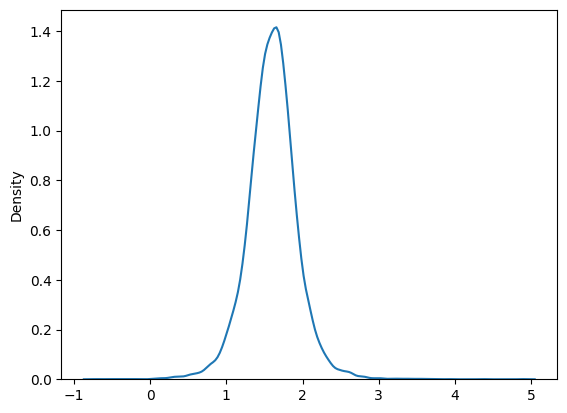

In [122]:
sns.kdeplot(gene_slopes)

In [123]:
alpha = 0.25
alpha*gene_slopes.mean() + (1-alpha)*2

np.float64(1.9008491490471093)

LinregressResult(slope=np.float64(1.7371748315506645), intercept=np.float64(-1.6392609937565839), rvalue=np.float64(0.34304424427855174), pvalue=np.float64(0.0), stderr=np.float64(0.029182814952806325), intercept_stderr=np.float64(0.04888159485420367))
1.7371748315506645


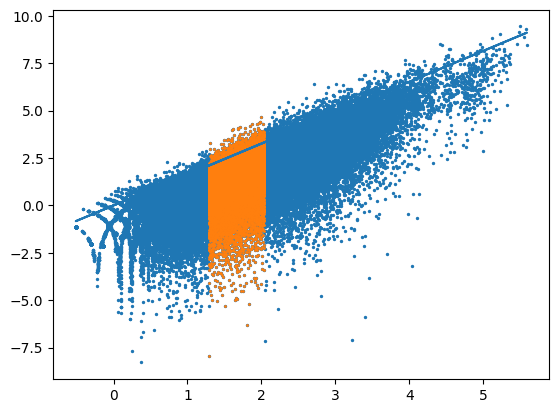

In [50]:
x = np.log10(all_pred.ravel())
y = np.log10(all_resid_variance.ravel())
select = (x > np.quantile(x, 0.3)) & ( x < np.quantile(x, .6))
mv_slope, _, _, _, _ = stats.linregress(x[select], y[select])
print(stats.linregress(x[select], y[select]))

plt.scatter(x, y, s=2)
plt.scatter(x[select], y[select], s=1)
plt.plot(x,1.63*x)
print(mv_slope)

In [61]:
stats.linregress()

LinregressResult(slope=np.float64(1.3961921909821162), intercept=np.float64(-0.12030958900738042), rvalue=np.float64(0.8924000029126415), pvalue=np.float64(0.0), stderr=np.float64(0.004399734714900315), intercept_stderr=np.float64(0.011688631509873783))

In [67]:
model.coef_

array([1.35224318])

[1.08797112]


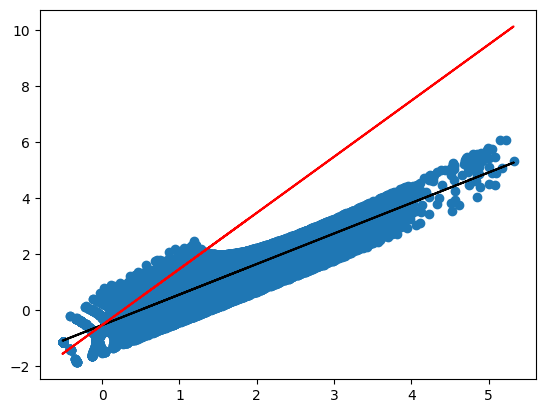

In [73]:
xs, ys = data[labels == 2, 0], data[labels == 2, 1]
plt.scatter(xs, ys)
model = linear_model.LinearRegression().fit(xs.reshape(-1,1), ys)
plt.plot(xs, model.predict(xs.reshape(-1,1),), color='k')
print(model.coef_)
model.coef_ = np.array([2])
plt.plot(xs, model.predict(xs.reshape(-1,1),), color='r')



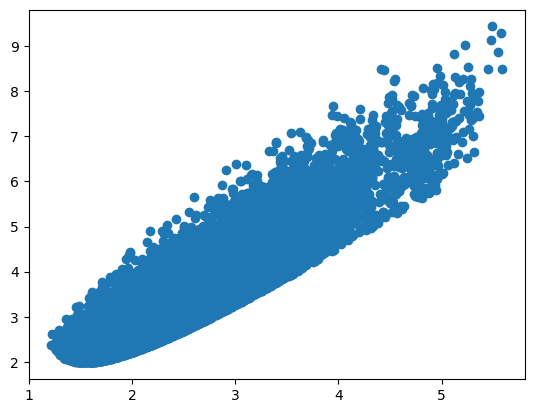

In [60]:
plt.scatter(data[labels == 0, 0], data[labels == 0, 1])

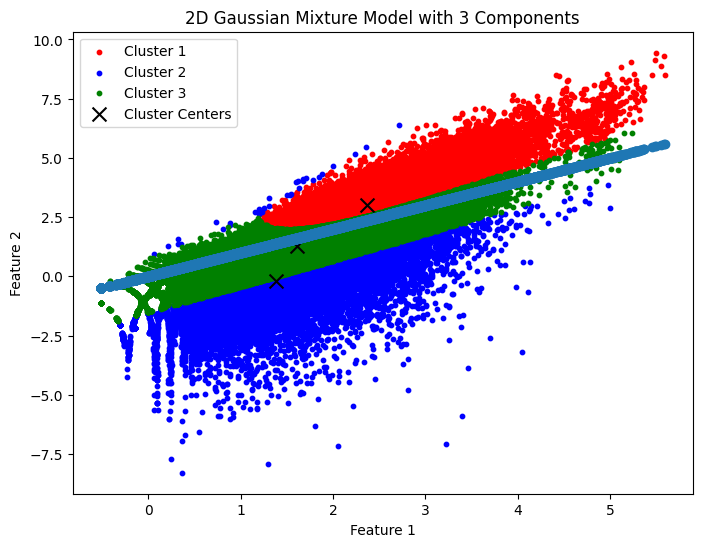

In [58]:
from sklearn.mixture import GaussianMixture

data = np.vstack([x,y]).T

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(data)

# Step 3: Get the predicted labels and component parameters
labels = gmm.predict(data)
means = gmm.means_
covariances = gmm.covariances_

# Step 4: Visualize the results
plt.figure(figsize=(8, 6))

# Scatter plot of the data points with colors based on labels
for i, color in enumerate(['red', 'blue', 'green']):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], s=10, color=color, label=f'Cluster {i + 1}')

# Plot the GMM means
plt.scatter(means[:, 0], means[:, 1], c='black', marker='x', s=100, label='Cluster Centers')


plt.scatter(x,x)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Gaussian Mixture Model with 3 Components')
plt.legend()
plt.show()


In [48]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(x.reshape(-1,1),y, sample_weight=np.clip(x, a_min=0, a_max=np.inf))
print(lr.coef_)

[1.6384615]


In [183]:
select = all_resid_variance>(sampling_variance.values+all_pred)

In [196]:
np.log10(all_pred[select].ravel()).mean()

np.float64(2.2788692836403004)

In [197]:
np.log10(all_resid_variance[select]).ravel().mean()

np.float64(2.959897385512908)

In [209]:
np.quantile(all_resid_variance[select], 0.5)/(np.quantile(all_pred[select], 0.5)**2)

np.float64(0.019404882208840516)

In [198]:
np.log10(all_resid_variance[select]).ravel().mean()-2*np.log10(all_pred[select].ravel()).mean()

np.float64(-1.5978411817676927)

<Axes: ylabel='Density'>

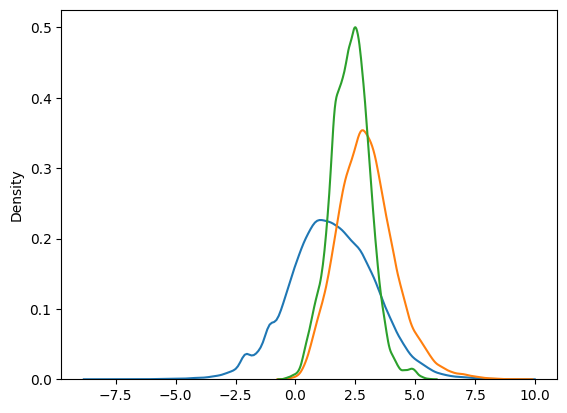

In [195]:
sns.kdeplot(np.log10(all_resid_variance).ravel())
sns.kdeplot(np.log10(all_resid_variance[select]).ravel())

sns.kdeplot(np.log10(all_pred[select].ravel()))

<Axes: ylabel='Density'>

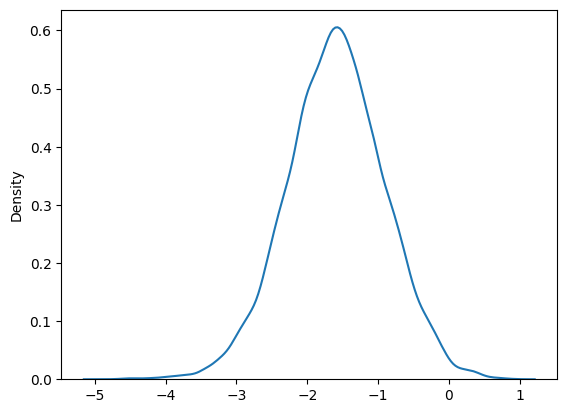

In [189]:
a = all_resid_variance[select]/(all_pred[select]**2)
# a[a < 0] = np.nan
# a = np.nanmean(a, axis=0)
sns.kdeplot(np.log10(a))

# 

In [37]:
10**np.log10((all_resid_variance/all_pred**2)).mean()

np.float64(0.008157539107645715)

In [43]:
a = (all_resid_variance/all_pred**2).mean(axis=0)

In [48]:
llim = np.quantile(all_resid_variance.ravel(), 0.05)
ulim = np.quantile(all_resid_variance.ravel(), 0.95)

In [50]:
all_resid_var_prime = all_resid_variance.copy()
all_resid_var_prime = np.clip(all_resid_var_prime, a_min=llim, a_max=ulim)

In [69]:
a = ((all_resid_var_prime)/all_pred**2)

In [73]:
all_resid_var_prime

array([[1.49108408e+03, 2.69586983e+03, 4.48100357e+00, ...,
        1.02547754e+00, 1.94459316e+02, 3.34382950e+01],
       [6.48396546e+01, 1.03762078e-01, 1.32649465e-01, ...,
        8.29753634e-02, 8.29753634e-02, 8.29753634e-02],
       [2.54874108e+02, 4.26398802e+02, 2.34196169e+01, ...,
        4.04391817e+01, 7.09644745e+01, 3.22097226e+01],
       ...,
       [6.04455740e+00, 1.10721714e+01, 3.57326997e+00, ...,
        7.63407859e-02, 7.63407859e-02, 7.63407859e-02],
       [3.53183720e+02, 3.72822627e+02, 3.24442075e+01, ...,
        4.22451445e+02, 3.29981412e+02, 2.00030728e+02],
       [1.23819568e+01, 2.01064839e-01, 4.26486478e-01, ...,
        4.82031893e-02, 4.82031893e-02, 4.82031893e-02]])

In [75]:
all_pred

array([[269.46993722, 256.71748222,  74.82225147, ...,  53.61288722,
         68.45876598,  38.26928711],
       [ 56.98287948,  21.06805605,   9.13508527, ...,   0.83777828,
          0.83777828,   0.83777828],
       [160.55260232, 152.9545754 ,  44.57976763, ...,  31.94303843,
         40.78834598,  22.80118405],
       ...,
       [ 20.96415035,   7.7509929 ,   3.36082176, ...,   0.30822082,
          0.30822082,   0.30822082],
       [288.87564741, 275.20483228,  80.21052944, ...,  57.473786  ,
         73.3887815 ,  41.02522605],
       [ 33.71868012,  12.46667506,   5.40553621, ...,   0.4957415 ,
          0.4957415 ,   0.4957415 ]])

In [ ]:
x = 

In [76]:
all_resid_var_prime sampling_variance

,FO538757.2,AP006222.2,RP11-206L10.9,LINC00115,NOC2L,PLEKHN1,ISG15,AGRN,C1orf159,TNFRSF18,...,NEFH,LIF,TMPRSS6,SMC1B,RIBC2,MAPK11,ODF3B,SYCE3,AP001347.6,JAM2
sg^D1^Th0,1179.000755,2415.468795,-104.749095,-20.938226,-604.213109,62.820604,-9.982904e+05,37.572650,-17.676368,11587.458270,...,-93.657241,6483.224398,737.461438,-79.597145,198.882286,-72.162272,-1.337015,-88.548662,125.857773,-6.507413
sg^D1^UNS,38.566683,-12.462796,-4.891174,-1.482750,-20.365859,1.239376,-6.381494e+01,-0.258158,-1.914132,1.418943,...,0.082973,0.082973,0.082973,0.082973,0.082973,0.082973,0.082973,0.082973,0.082973,0.082973
sg^D2^Th0,77.704835,227.032463,-23.827744,-14.644568,-28.326395,1107.958806,-8.206320e+05,258.975938,21.302987,11459.601011,...,-55.124262,6625.332054,-48.520058,111.376812,-16.424561,74.552276,-267.420667,-11.390071,6.557134,11.957872
sg^D2^UNS,-30.788440,3.596857,-3.156125,-2.344892,-41.938887,-0.180318,-6.292539e+01,-0.342018,-2.373784,0.378258,...,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200
sg^D3^Th0,807.385773,2375.854092,-84.484281,103.827643,6182.394046,428.337784,-1.138285e+06,836.261601,-51.206925,15917.145818,...,-108.029369,-4373.487130,4532.480599,-145.026242,-36.894445,573.546276,456.611520,738.288161,79.262459,-47.375390
sg^D3^UNS,-5.470811,4.975679,0.895848,-0.862996,-15.092689,0.077871,-2.302427e+01,0.048198,-0.575570,0.048198,...,0.076336,0.076336,0.076336,0.076336,0.076336,0.076336,0.076336,0.076336,0.076336,0.076336
sg^D4^Th0,-17.953934,-28.566334,-68.497191,400.146037,4342.671123,-70.090986,-1.932688e+06,-97.892109,-39.447340,19288.262321,...,-139.137874,-3772.922390,1462.865145,91.220609,89.465436,74.331553,2038.701565,305.805741,203.759365,74.515197
sg^D4^UNS,-8.726545,-8.252612,-1.977113,-1.521201,-4.127464,-0.535410,-3.930970e+01,0.048200,-1.666348,0.193206,...,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200,0.048200


In [70]:
a[all_resid_var_prime>all_pred].mean()

np.float64(0.08310935469225793)

In [64]:
np.median(a[a > 0])

np.float64(0.013309574499167016)

In [44]:
np.argsort(a

array([4569, 4893, 9827, ..., 2815, 8621, 6540])

In [45]:
all_pred[:, 6540]

array([56.74536866,  2.74753932, 33.80939893,  2.34954295, 62.01232035,
        1.0108269 , 60.83185115,  1.62581112])

In [47]:
all_endog[:, 6540]

array([ 20.77295324,   0.54972384,   6.55857696,   0.63331501,
        15.2646014 ,   0.58451918, 170.80280749,   5.96616225])

In [33]:
all_resid_variance[:, 1414]

array([1.32792050e+00, 5.39169784e+02, 1.40184978e+00, 2.01199087e+03,
       1.99446300e+00, 6.65927048e+01, 1.90608822e+00, 1.81569052e+02])

In [18]:
vec = (all_resid_variance/all_endog**2).ravel()

In [24]:
np.argsort(vec)

array([ 8092, 23384,  7252, ..., 32143, 52982, 12485])

In [23]:
vec

array([0.02797835, 0.06427723, 0.00075697, ..., 0.02579862, 0.02579862,
       0.02579862])

In [20]:
stats.trimboth(vec, 0.01).mean()

np.float64(0.05391730987510487)

In [15]:
10**-2.071750596352643

0.008477140938016728

In [81]:
point_dispersions = ((all_resid_variance-all_pred)/all_pred**2)
mv_df = pd.DataFrame(
    zip(
        np.log10(all_pred.ravel()), 
        np.log10(point_dispersions.ravel()),
        np.log10(all_resid_variance.ravel())),
    columns=['point_mean', 'point_dispersion', 'point_variance'])
mv_df = mv_df.sort_values('point_mean')

mv_df['filled_point_dispersion'] = mv_df['point_dispersion']\
    .interpolate(method='linear')\
    .bfill()
alpha = 0.5
mv_df['final_point_dispersions'] = mv_df['filled_point_dispersion'].rolling(window=5, min_periods=1).mean().values
mv_df['expected_point_variance'] = mv_df['point_variance'].rolling(window=1000, min_periods=1).mean().values
mv_df['final_point_variance'] = (1-alpha)*mv_df['point_variance'] + alpha*mv_df['expected_point_variance']

num_pieces = 20

    
    
order = np.argsort(all_pred.ravel())
revert_order = np.argsort(order)

shrinked_dispersions = 10**mv_df['final_point_dispersions'].values[revert_order].reshape(all_pred.shape).mean(axis=0)
all_resid_variances_shrinked = mv_df['final_point_variance'].values[revert_order].reshape(all_pred.shape)
    
# dispersions_df['my_shrinked_disp'] = shrinked_dispersions

/tmp/ipykernel_259443/4276593291.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(point_dispersions.ravel()),


LinregressResult(slope=np.float64(1.5874586925655936), intercept=np.float64(-1.4041280462465169), rvalue=np.float64(0.9986125149986956), pvalue=np.float64(0.0), stderr=np.float64(0.00031449071047405633), intercept_stderr=np.float64(0.0005985118337199903))
1.5874586925655936


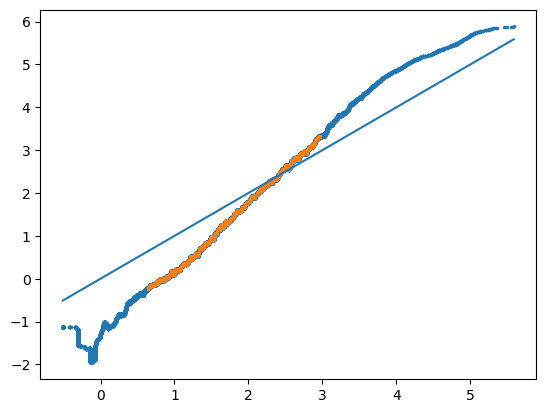

In [82]:
x = mv_df['point_mean'].values
y = mv_df['expected_point_variance'].values
select = (x > np.quantile(x, 0.1)) & ( x < np.quantile(x, 0.9))
mv_slope, _, _, _, _ = stats.linregress(x[select], y[select])
print(stats.linregress(x[select], y[select]))

plt.scatter(x, y, s=2)
plt.scatter(x[select], y[select], s=1)
plt.plot(x,x)
print(mv_slope)

In [83]:
def compute_local_gradients_sparse(x, y, bandwidth=1.0, num_points=1000, cutoff_factor=3.0):
    """
    Computes the local gradients (slopes) at evenly spaced points using local linear regression with a cutoff.
    
    Parameters:
    x (array-like): 1D array of x-coordinates.
    y (array-like): 1D array of y-coordinates.
    bandwidth (float): Bandwidth parameter for the Gaussian kernel.
    num_points (int): Number of points to evaluate gradients at.
    cutoff_factor (float): Multiplier for the bandwidth to determine cutoff distance.
    
    Returns:
    numpy.ndarray: Gradients at evenly spaced points.
    numpy.ndarray: The x-coordinates of the evaluated points.
    """
    x = np.array(x)
    y = np.array(y)
    gradients = []
    x_eval = np.linspace(x.min(), x.max(), num_points)  # Points to evaluate gradients
    cutoff_distance = cutoff_factor * bandwidth

    for x_0 in x_eval:
        # Find points within the cutoff distance
        distances = np.abs(x - x_0)
        mask = distances <= cutoff_distance
        x_subset = x[mask]
        y_subset = y[mask]
        weights = np.exp(-0.5 * ((x_subset - x_0) / bandwidth) ** 2)

        # Compute weighted sums
        w_sum = np.sum(weights)
        wx_sum = np.sum(weights * x_subset)
        wy_sum = np.sum(weights * y_subset)
        wxx_sum = np.sum(weights * x_subset * x_subset)
        wxy_sum = np.sum(weights * x_subset * y_subset)

        # Solve for the slope directly
        denominator = w_sum * wxx_sum - wx_sum ** 2
        if denominator == 0:
            gradients.append(0.0)
        else:
            slope = (w_sum * wxy_sum - wx_sum * wy_sum) / denominator
            gradients.append(slope)

    return np.array(gradients), x_eval
x = mv_df['point_mean'].values
y = mv_df['point_variance'].values
select = (x > np.quantile(x, 0.1)) & ( x < np.quantile(x, 0.99))
slope, x_values = compute_local_gradients_sparse(
    x, y, bandwidth=0.5, num_points=500, cutoff_factor=5.0)
limits = (x[select].min(), x[select].max())
slope[(x_values > limits[0])&(x_values < limits[1])].max()

np.float64(1.7945277705950953)

In [84]:
find_mode_continuous(slope)

NameError: name 'find_mode_continuous' is not defined

In [ ]:
limits = (x[select].min(), x[select].max())

In [ ]:
limits

(np.float64(0.6389352240997132), np.float64(3.9534312931181823))

In [ ]:
limits = (x[select].min(), x[select].max())
slope[(x_values > limits[0])&(x_values < limits[1])].max()

np.float64(1.7945277705950953)

In [91]:
z = np.log10(sampling_variance.values.ravel())

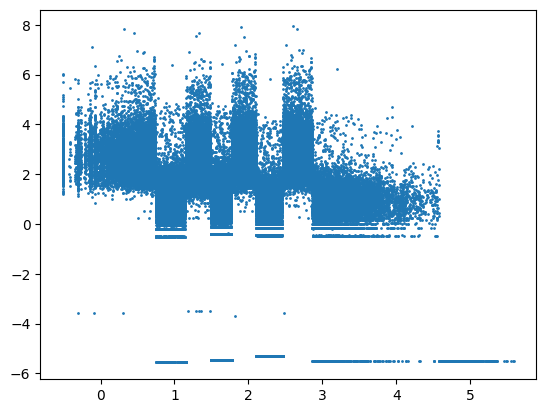

In [95]:
plt.scatter(x,z, s=1)

In [87]:
(y-2*x).max()

np.float64(0.9601932161478537)

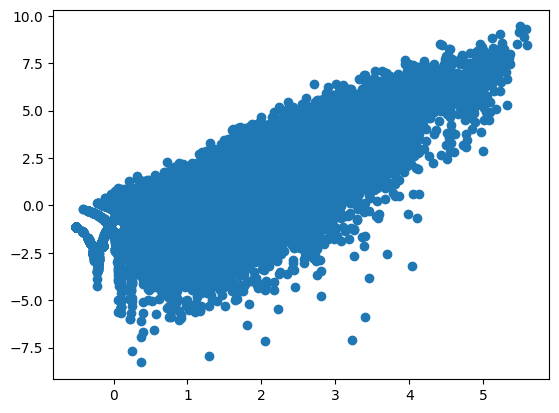

In [85]:
plt.scatter(x,y)

In [97]:
all_pred**2

array([[7.26140471e+04, 6.59038657e+04, 5.59836931e+03, ...,
        2.87434168e+03, 4.68660264e+03, 1.46453834e+03],
       [3.24704855e+03, 4.43862986e+02, 8.34497829e+01, ...,
        7.01872450e-01, 7.01872450e-01, 7.01872450e-01],
       [2.57771381e+04, 2.33951021e+04, 1.98735568e+03, ...,
        1.02035770e+03, 1.66368917e+03, 5.19893994e+02],
       ...,
       [4.39495600e+02, 6.00778910e+01, 1.12951229e+01, ...,
        9.50000742e-02, 9.50000742e-02, 9.50000742e-02],
       [8.34491397e+04, 7.57376997e+04, 6.43372903e+03, ...,
        3.30323608e+03, 5.38591325e+03, 1.68306917e+03],
       [1.13694939e+03, 1.55417987e+02, 2.92198217e+01, ...,
        2.45759631e-01, 2.45759631e-01, 2.45759631e-01]])

In [96]:
all_resid_variance.mean()

np.float64(220726.76037622336)

In [99]:
np.median(all_pred.mean(axis=0))

np.float64(145.46079116151736)

In [ ]:
slope.max()

np.float64(2.0357209670408674)

<Axes: ylabel='Density'>

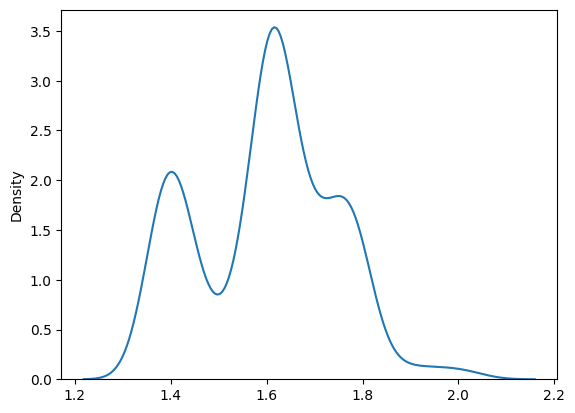

In [ ]:
sns.kdeplot(slope)

In [ ]:
knots

array([-0.51113803,  0.09870868,  0.70855539,  1.31840209,  1.9282488 ,
        2.53809551,  3.14794221,  3.75778892,  4.36763563,  4.97748233,
        5.58732904])

In [ ]:
slopes.max()

AttributeError: 'list' object has no attribute 'max'

In [ ]:
plt.scatter(x,y)
for knot in range(num_pieces):
    
    

SyntaxError: incomplete input (3188830268.py, line 4)

In [ ]:
# local linear regressions approach


In [ ]:
y_hat = savgol_filter(x, y

In [ ]:
x, y = x[select], y[select]

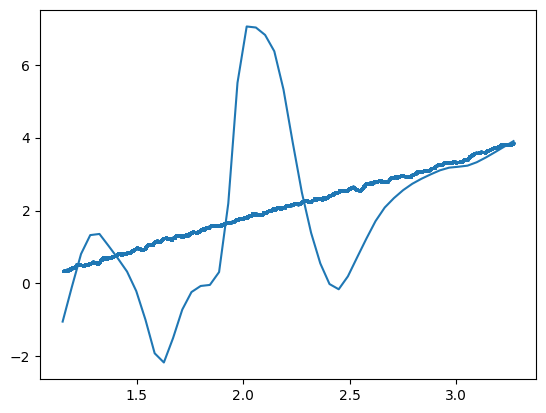

In [ ]:
plt.scatter(x,y, s=1)
spl = make_smoothing_spline(x,y, lam=1)
x_range = np.linspace(x.min(), x.max(), 50)
plt.plot(x_range, spl(x_range))

In [ ]:
x = np.log10(all_pred.ravel())
y = np.log10(all_resid_variance.ravel())
select = (x > np.quantile(x, 0.3)) & ( x < np.quantile(x, 0.6))
mv_slope, _, _, _, _ = stats.linregress(x[select], y[select])
mv_slope2, _, _, _ = np.linalg.lstsq(x[select][:, np.newaxis], y[select])
print(mv_slope, mv_slope2)

1.27671491853074 [2.40173067]


In [ ]:
dataset_to_use

'CD4_Naive-Th0'

LinregressResult(slope=np.float64(1.7371748315506645), intercept=np.float64(-1.6392609937565845), rvalue=np.float64(0.3430442442785516), pvalue=np.float64(0.0), stderr=np.float64(0.02918281495280633), intercept_stderr=np.float64(0.048881594854203694))
1.7371748315506645


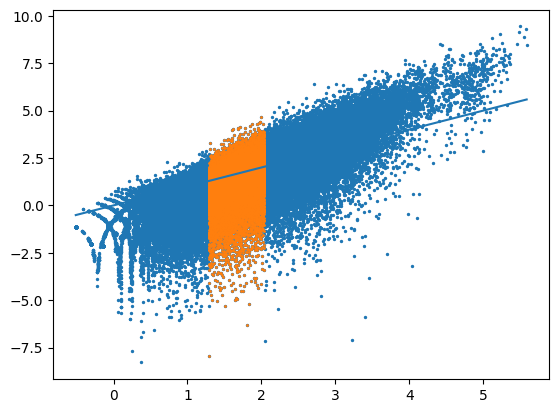

In [114]:
x = mv_df['point_mean'].values
y = mv_df['point_variance'].values
select = (x > np.quantile(x, 0.3)) & ( x < np.quantile(x, 0.6))
mv_slope, _, _, _, _ = stats.linregress(x[select], y[select])
print(stats.linregress(x[select], y[select]))

plt.scatter(x, y, s=2)
plt.scatter(x[select], y[select], s=1)
plt.plot(x,x)
print(mv_slope)

LinregressResult(slope=np.float64(1.7371748315506645), intercept=np.float64(-1.6392609937565845), rvalue=np.float64(0.3430442442785516), pvalue=np.float64(0.0), stderr=np.float64(0.02918281495280633), intercept_stderr=np.float64(0.048881594854203694))
1.7371748315506645


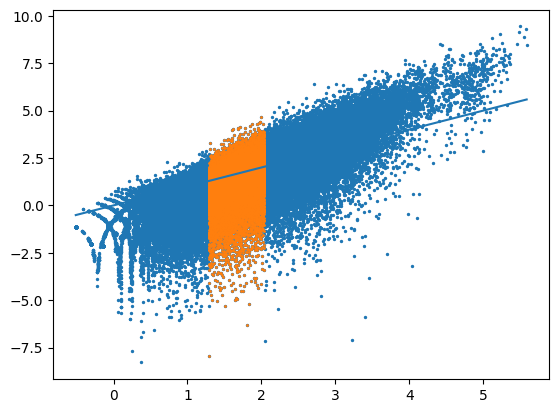

In [125]:
x = mv_df['point_mean'].values
y = mv_df['point_variance'].values
z = np.log10(sampling_variance.values.ravel())
selec = (x > np.quantile(x, 0.3)) & ( x < np.quantile(x, 0.6))
mv_slope, _, _, _, _ = stats.linregress(x[select], y[select])
print(stats.linregress(x[select], y[select]))

plt.scatter(x, y, s=2)
plt.scatter(x[select], y[select], s=1)
plt.plot(x,x)
print(mv_slope)

In [128]:
10**x.mean()

np.float64(63.62225592519202)

In [ ]:
%%time
select = (x > np.quantile(x, 0.2)) & ( x < np.quantile(x, 0.99))
bandwidth = 0.5
local_gradients, pos  = compute_local_gradients(x[select], y[select], bandwidth, cutoff_factor=3)

CPU times: user 912 ms, sys: 0 ns, total: 912 ms
Wall time: 912 ms


In [ ]:
np.quantile(local_gradients, .95)

np.float64(1.7674128262782187)

In [ ]:
gene_slopes = np.zeros(all_pred.shape[1])
gene_intercepts = np.zeros(all_pred.shape[1])

for idx in range(all_pred.shape[1]):

    e = all_endog[:, idx]
    m = all_pred[:, idx]
    v = all_resid_variance[:, idx]
    slope, inter, _, _, _ = stats.linregress(np.log10(m),np.log10(v))
    
    gene_slopes[idx] = slope
    gene_intercepts[idx] = inter
    

In [ ]:
gene_intercepts

array([-2.13250128, -2.27628283, -0.87895395, ..., -1.12884087,
       -1.09508478, -1.11515203])

In [ ]:
np.mean(gene_slopes)

np.float64(1.6469835936082915)

In [ ]:
3*np.median(gene_slopes)-2*np.mean(gene_slopes)

np.float64(1.6763230081054585)

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

In [ ]:
def find_mode_continuous(x, bandwidth='scott', grid_size=1000):
    """
    Estimates the mode of a continuous distribution using KDE.
    
    Parameters:
        x (array-like): Observed values of the continuous variable.
        bandwidth (str or float): Bandwidth for KDE. Default is 'scott'.
        grid_size (int): Number of grid points for KDE evaluation. Default is 1000.
    
    Returns:
        float: Estimated mode of the distribution.
    """
    if len(x) == 0:
        raise ValueError("Input array x cannot be empty.")
    
    # Kernel density estimation
    kde = gaussian_kde(x, bw_method=bandwidth)
    
    # Create a grid over the range of x
    grid = np.linspace(min(x), max(x), grid_size)
    kde_values = kde(grid)
    
    # Find the mode (grid point with the maximum density)
    mode = grid[np.argmax(kde_values)]
    return mode


In [ ]:
find_mode_continuous(gene_slopes)

np.float64(1.735078155495001)

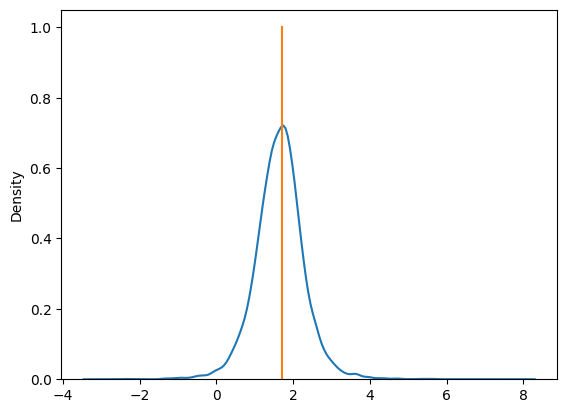

In [ ]:
sns.kdeplot(gene_slopes)
plt.plot([1.7, 1.7], [0, 1])

In [ ]:
np.median(gene_intercepts)

np.float64(-1.3140503848416345)

<Axes: ylabel='Density'>

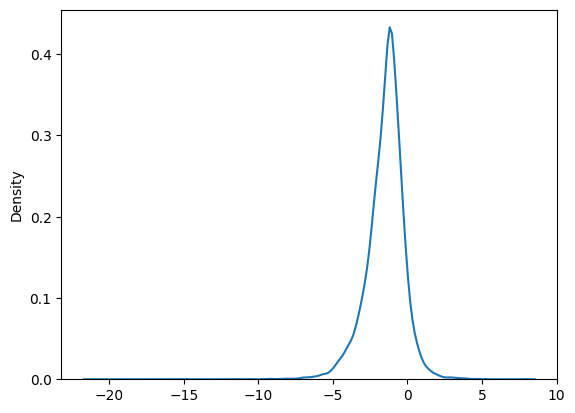

In [ ]:
sns.kdeplot(gene_intercepts)

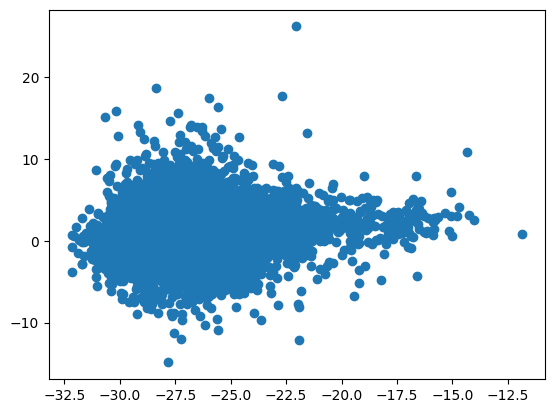

In [ ]:
plt.scatter(np.log(all_resid_variance.mean(axis=0)), gene_slopes)
# plt.plot([0, 20], [2, 2], color='k')
# plt.plot([0, 20], [1.64, 1.64], color='k')

In [ ]:
num_trials = 5000
num_genes_per_trial = 2
randomized_slopes = np.zeros(num_trials)
randomized_intercepts = np.zeros(num_trials)
for trial in range(num_trials):
    
    selected_genes = np.random.randint(num_genes, size=num_genes_per_trial)
    
    m = all_pred[:, selected_genes].ravel()
    v = all_resid_variance[:, selected_genes].ravel()

    randomized_slopes[trial], randomized_intercepts[trial], _, _, _ = stats.linregress(np.log10(m),np.log10(v))


<Axes: ylabel='Density'>

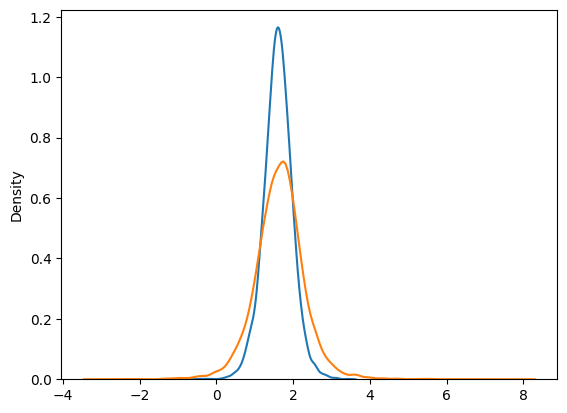

In [ ]:
sns.kdeplot(randomized_slopes)
sns.kdeplot(gene_slopes)

In [ ]:
find_mode_continuous(stats.trimboth(gene_slopes, 0.05), grid_size=5000)

np.float64(1.7537128983281995)

In [ ]:
find_mode_continuous(stats.trimboth(randomized_slopes, 0.05), grid_size=5000)

np.float64(1.6007449168892416)

In [ ]:
# metric1 = all_pred.max(axis=0) - all_pred.min(axis=0)
# metric2 = all_pred.mean(axis=0)
metric = all_resid_variance.mean(axis=0)

mask = metric > np.quantile(metric, 0.9)
print(gene_slopes[mask].mean())
log10_arv = np.log10(all_resid_variance[:, mask])
log10_pred = np.log10(all_pred[:, mask])
gene_inter_2d = gene_intercepts[np.newaxis, mask]

log10_arv_bar = log10_arv.mean(axis=0)
log10_pred_bar = log10_pred.mean(axis=0)

1.940081022650167


In [ ]:
np.median(gene_slopes[mask])

np.float64(1.9294768584964517)

In [ ]:
def objective(s):
    
    new_intercepts = (log10_arv_bar-s*log10_pred_bar)[np.newaxis, :]
    return ((log10_arv - (s*log10_pred+new_intercepts)  )**2).mean()

In [ ]:
from scipy.optimize import minimize

In [ ]:
minimize(objective, 0, options={'maxiter':10000}).x

array([1.66371153])

In [109]:
sampling_variance.values.mean()

np.float64(12217.124083949844)

In [ ]:
objective(0)

np.float64(410431.91327788314)

In [ ]:
objective(1.6)

np.float64(975925.8448259915)

In [ ]:
order = np.argsort(all_pred.mean(axis=0))
revert_order = np.argsort(order)

In [ ]:
window_size=5
sorted_all_pred = all_pred[:, order]
sorted_all_rv = all_resid_variance[:, order]
slopes = np.zeros(num_genes)
for i in range(num_genes):
    start_idx, end_idx = i, i+window_size
    m = sorted_all_pred[:, start_idx:end_idx].ravel()
    v = sorted_all_rv[:, start_idx:end_idx].ravel()
    slope, inter, _, _, _ = stats.linregress(np.log10(m),np.log10(v))

    # plt.figure()
    # plt.scatter(np.log10(m),np.log10(v))
    # plt.title(slope)
    slopes[i] = slope

In [ ]:
stats.linregress(x,y)

LinregressResult(slope=np.float64(1.5767774661916671), intercept=np.float64(-3.051185065724985), rvalue=np.float64(0.8221510522576249), pvalue=np.float64(0.0), stderr=np.float64(0.003668623220448086), intercept_stderr=np.float64(0.017086471629821923))

In [118]:
all

array([[269.46993722, 256.71748222,  74.82225147, ...,  53.61288722,
         68.45876598,  38.26928711],
       [ 56.98287948,  21.06805605,   9.13508527, ...,   0.83777828,
          0.83777828,   0.83777828],
       [160.55260232, 152.9545754 ,  44.57976763, ...,  31.94303843,
         40.78834598,  22.80118405],
       ...,
       [ 20.96415035,   7.7509929 ,   3.36082176, ...,   0.30822082,
          0.30822082,   0.30822082],
       [288.87564741, 275.20483228,  80.21052944, ...,  57.473786  ,
         73.3887815 ,  41.02522605],
       [ 33.71868012,  12.46667506,   5.40553621, ...,   0.4957415 ,
          0.4957415 ,   0.4957415 ]])

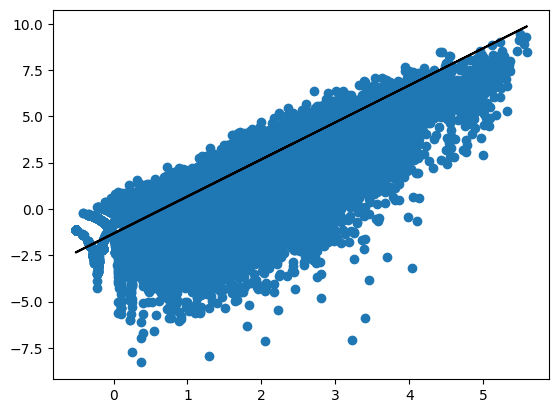

In [110]:
x = np.log10(all_pred.ravel())
y = np.log10(all_resid_variance.ravel())
plt.scatter(x,y)
a, b, _, _, _ = stats.linregress(x,y)
plt.plot(x,2*x+b, color='k')

In [113]:
10**4

1000

In [112]:
10**1

10

In [111]:
x.mean()

np.float64(1.803609064307535)

<Axes: ylabel='Density'>

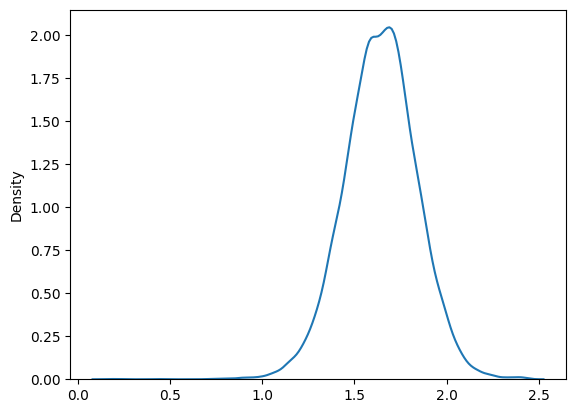

In [ ]:
sns.kdeplot(slopes)

In [ ]:
# idx = 0
# plt.scatter(
#     np.log(all_pred[[0, 2, 4, 6], idx]),
#     np.log(all_resid_variance[[0, 2, 4, 6], idx]))
# plt.scatter(
#     np.log(all_pred[[1, 3, 5, 7], idx]),
#     np.log(all_resid_variance[[1, 3, 5, 7], idx]))
# plt.plot([-2, 6], [0, 0], color='k')
# plt.plot([0, 0], [-10, 10], color='k')
# x_range = np.linspace(-2, 10, 100)
# plt.scatter(x_range, 2*x_range)

In [ ]:
all_pred[:, idx]

array([1165.3784517 ,   53.5119877 , 1369.5075424 ,   45.76047831,
       1472.91689494,   19.68720019, 1062.09083593,   31.66483709])

In [ ]:
all_resid_variance[:, idx]

array([3.79591744e+02, 5.61801889e+00, 1.63079686e+03, 5.30620526e+00,
       2.29737259e+04, 9.43242196e-01, 2.97462019e+04, 1.37088740e+01])

In [ ]:
np.median(all_resid_variance.ravel())

np.float64(23.788443426924715)

<Axes: ylabel='Density'>

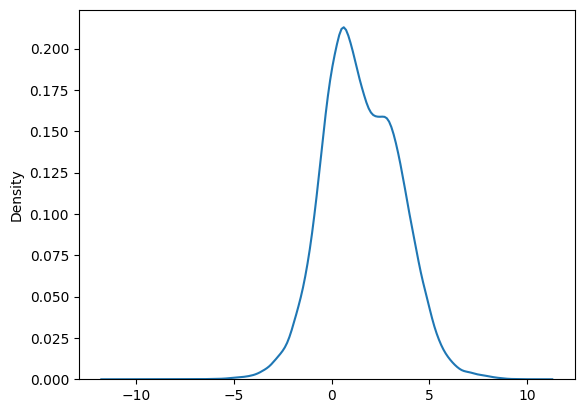

In [ ]:
sns.kdeplot(np.log10(all_resid_variance.ravel()))

In [100]:
result = []
error_counter = 0
for idx, fit in enumerate(regression_fits):
    coef = fit['model'].params[fit['t']]
    X = fit['design'].values
    pred = fit['pred']
    endog = fit['endog']

    # intra_var = quasi_nb_var(pred, intra_var_scale, intra_var_dispersion)
    intra_var = sampling_variance[fit['gene']].values
    disp = dispersions_df.loc[fit['gene'], 'dispersion'] if fit['gene'] in dispersions_df.index else dispersions_df['dispersion'].mean()
    inter_var = 0.3*pred**2
    
    total_var = intra_var + inter_var

    try:
        W = (pred**2) / total_var
        var = np.diag(np.linalg.pinv(X.T@np.diag(W)@X))[-1]
        se = np.sqrt(var)
        pv = 2*stats.norm.sf(np.abs(coef/se))
    except:
        # logging.error(', '.join([
        #     f'differential_mean: gene: {fit["gene"]}',
        #     f'treatment: {fit["t"]}', 
        #     f'intra: {intra_var}', 
        #     f'inter_var: {inter_var}',
        #     f'global_disp: {global_dispersion}',
        #     ]))
        se, pv = np.nan, np.nan
        error_counter+=1

    result.append((fit['gene'], fit['t'], coef, se, pv))

temp = pd.DataFrame(result, columns=['gene', 'treatment', 'coef', 'se','pval']).set_index('gene')
fdr = temp['pval'].values.copy()
_, val_fdr = fdrcorrection(fdr[np.isfinite(fdr)])
fdr[np.isfinite(fdr)] = val_fdr
temp['fdr'] = fdr

<Axes: >

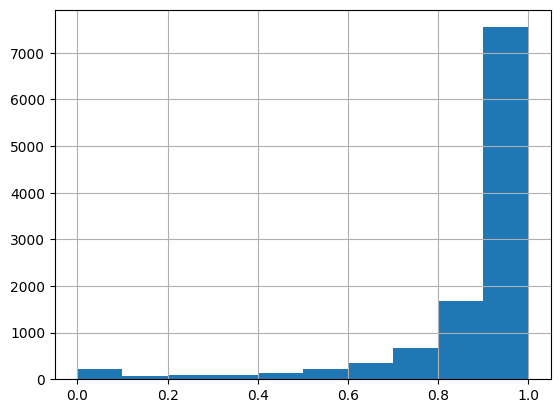

In [101]:
temp['pval'].hist()

### Compare against bulk

In [102]:
def concordance_curve(refs, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
        overlap.append(ref_total/len(refs))
        
    return np.arange(1, k+1), np.array(overlap)
def concordance_auc(refs, x, k=300):
    count = 0
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
            
        count += ref_total/len(refs)
        
    return count / (k*(k+1)/2)

### Read results - cell type comparison

In [103]:
datasets = [
    'CD4_Memory-Th0',
    'CD4_Memory-Th2',
    'CD4_Memory-Th17',
    'CD4_Memory-iTreg',
    'CD4_Naive-Th0',
    'CD4_Naive-Th2',
    'CD4_Naive-Th17',
    'CD4_Naive-iTreg'
]

bulk_methods = [
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
    # ('bulk_limma,mode?voom',['gene', 'logFC', 'P.Value', 'adj.P.Val'])
]

sc_methods = [ 
    # ('LR',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('MAST',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('bimod',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('negbinom',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('poisson',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('pseudobulk_limma,mode?voom',['gene','avg_logFC', 'p_val', 'p_val_adj']),
    # ('t',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    # ('wilcox',['gene','avg_log2FC', 'p_val', 'p_val_adj']),
    ('TEST', ['coef', 'pval', 'fdr']),
    # ('quasiML', ['coef', 'pval', 'fdr']),

    ('quasiGLM', ['coef', 'pval', 'fdr']),
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
    # ('MAST', ['coef', 'Pr(>Chisq)','fdr']),
    ('t',['logFC', 'PValue', 'fdr']),
    ('MWU',['logFC', 'PValue', 'fdr']),
    # ('memento_glm_vanilla',['logFC', 'PValue', 'FDR']), # full cells

]

In [104]:
import os

In [105]:
path = '/data_volume/bulkrna/canogamez/'

In [106]:
conversion = pd.read_csv('conversion.txt', sep='\t', header=None)
conversion_dict = dict(zip(conversion.iloc[:, 0], conversion.iloc[:, 1]))

In [107]:
def read_bulk_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path + 'bulk_results/{}_{}.csv'.format(dataset, method), index_col=0)
    df = df.rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))
    df.index = [conversion_dict[x] for x in df.index]
    # df.index = df['gene']
    return df

def read_sc_dataset(dataset, method, cols, trial):
    
    if method == 'TEST':
        df = temp
    else:
        df = pd.read_csv(data_path +  'sc_results/{}_{}_{}.csv'.format(dataset, trial, method), index_col=0)
    df = df.rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))
    # df.index = df['gene']
    return df

def read_sampled_dataset(dataset, method, cols, trial):
    
    df = pd.read_csv(data_path +  'sc_results/{}_{}_{}.csv'.format(dataset, trial, method), index_col=0)
    df = df.rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))
    # df.index = df['gene']
    return df

all_results = []
small_results = []
for dataset in [dataset_to_use]:
    print(dataset)
    for trial in range(1,1+1):
        
        bulk_results = [read_bulk_dataset(dataset, method, cols) for method, cols in bulk_methods]

        sc_results = [read_sc_dataset(dataset, method, cols, 1) for method, cols in sc_methods]
        # sc_results[0] = temp.rename(columns=dict(zip(['coef', 'pval', 'fdr'],['logFC','PValue', 'FDR'])))
        

        gene_list = [set(res.index) for res in sc_results] + [set(res.index) for res in bulk_results]#+ [set(res.index) for res in sampled_results]
        genes = list(functools.reduce(lambda x,y: x & y, gene_list))

        bulk_results = [res.loc[genes].sort_values('FDR') for res in bulk_results]
        sc_results = [res.loc[genes].sort_values('FDR') for res in sc_results]


        scores = [(sc_methods[idx][0], dataset, trial, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sc_results)]

        all_results+=scores


CD4_Naive-Th0


In [108]:
scores

[('TEST', 'CD4_Naive-Th0', 1, 0.0075247524752475245),
 ('quasiGLM', 'CD4_Naive-Th0', 1, 0.4085148514851485),
 ('deseq2_lrt', 'CD4_Naive-Th0', 1, 0.22787128712871288),
 ('deseq2_wald', 'CD4_Naive-Th0', 1, 0.21287128712871287),
 ('edger_lrt', 'CD4_Naive-Th0', 1, 0.3764851485148515),
 ('edger_qlft', 'CD4_Naive-Th0', 1, 0.3388613861386139),
 ('t', 'CD4_Naive-Th0', 1, 0.024455445544554456),
 ('MWU', 'CD4_Naive-Th0', 1, 0.0549009900990099)]

In [1251]:
temp.head(5)

,treatment,coef,se,pval,fdr
gene,,,,,
FO538757.2,stim,-0.099898,0.770259,0.896808,0.924967
AP006222.2,stim,-1.046411,0.810842,0.196869,0.321513
RP11-206L10.9,stim,-0.649185,0.699108,0.353101,0.470100
LINC00115,stim,-0.649385,0.888081,0.464643,0.572246
NOC2L,stim,-0.476837,0.674520,0.479611,0.585422


<Axes: >

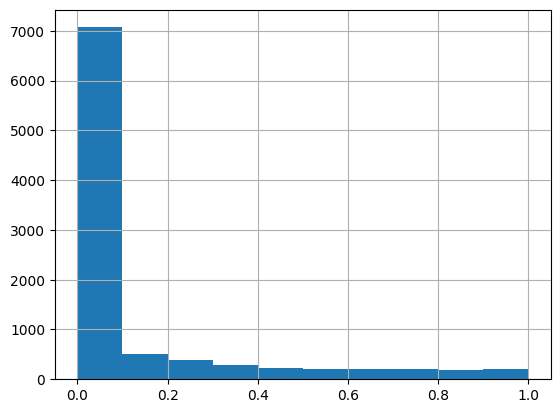

In [ ]:
sc_results[5]['PValue'].hist()

### Current implementation

In [ ]:
import os

%load_ext autoreload


%autoreload 2

import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')

import memento
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

trial = 1
dataset = dataset_to_use
adata = sc.read_h5ad(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))

gene_list = adata.var.index[adata.X.mean(axis=0).A1 > 0.02].tolist()

adata.obs['q'] = 0.07
memento.setup_memento(
    adata, 
    'q', 
    filter_mean_thresh=0.02, 
    estimator_type='pseudobulk')

memento.create_groups(adata, label_columns=['donor.id', 'cytokine.condition'])

memento.compute_1d_moments(adata, min_perc_group=0, gene_list=gene_list)

condition = 'UNS'
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]
cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==condition).astype(float)
cov_df = sm.add_constant(cov_df)[['const']]

temp2 = memento.main.ht_mean(
    adata=adata, 
    treatment=stim_df,
    covariate=cov_df,
    treatment_for_gene=None,
    covariate_for_gene=None,
    inplace=True, 
    num_boot=2000, 
    verbose=1,
    num_cpus=14,
    return_stats=False)

In [ ]:
temp2 = memento.get_mean_ht_result(adata)
fdr = temp2['de_pval'].values.copy()
_, val_fdr = fdrcorrection(fdr[np.isfinite(fdr)])
fdr[np.isfinite(fdr)] = val_fdr
temp2['fdr'] = fdr
temp2.set_index('gene', inplace=True)

# OLD

In [ ]:
total_umi

In [ ]:
intra_var

In [ ]:
inter_var

In [ ]:
global_dispersion

In [ ]:
total_var

In [ ]:
pred

In [ ]:
temp['pval'].hist()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from patsy import dmatrix, dmatrices 
import statsmodels.api as sm
import logging
import pickle as pkl
from scipy.optimize import minimize
import os

In [ ]:
import sys
sys.path.append('/home/ubuntu/Github/memento/')

import memento.model.rna as rna
import memento.estimator.hypergeometric_rna as hg
import memento.util as util

logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

In [ ]:
data_path = '/data_volume/bulkrna/canogamez/'

In [ ]:
trial = 1
dataset = 'CD4_Memory-Th0'
    
print(dataset)
ct, stim = dataset.split('-')

adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))

dispersion = pd.read_csv(data_path + 'sc_results/{}_{}_dispersions.csv'.format(dataset, trial), index_col=0)
# gene_list = dispersions['gene'].tolist()
# dispersions = dispersions['dispersion'].tolist()
adata.obs['q'] = 0.07
adata.X = adata.X.astype(float)

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['donor.id', 'cytokine.condition'],
        num_bins=30)

# adata = adata[:, dispersion.index]
adata = adata[:, adata.X.mean(axis=0).A1 > 0.02]


model = rna.MementoRNA(adata=adata)

model_save_name = f'{dataset}_estimates'

if model_save_name in os.listdir():
    model.load_estimates(model_save_name)
else:
    model.compute_estimate(
        estimand='mean',
        get_se=True,
        n_jobs=30,
    )
    model.save_estimates(model_save_name)

In [ ]:
adata.obs.head(2)

In [ ]:
sns.boxplot(y='nUMI', x='cytokine.condition', data=adata.obs)

In [ ]:
def quasi_nb_var(mean, scale, dispersion):
    
    return scale*(mean + dispersion*mean**2)


def quasi_nb_objective(scale, dispersion, mean, variance):
    
    pred_y = np.log(quasi_nb_var(mean, scale, dispersion))
    y = np.log(variance)
    
    return ((pred_y-y)**2).mean()
    

def fit_quasi_nb(mean, variance):

    dispersion0 = 1
    scale0 = np.median((mean/variance))
        
    optim_obj = lambda params: quasi_nb_objective(params[0], params[1], mean, variance)

    res =  minimize(
        optim_obj, 
        [scale0, dispersion0],
        bounds=[(1e-5,None), (1e-10, 10)],
    )
    return res.x

In [ ]:
test_estimates = model.estimates

In [ ]:
n_groups = test_estimates['mean'].shape[0]

# "Counts" to use in GLM
expr = (
    test_estimates['mean']/
    model.adata.uns['memento']['umi_depth']*
    test_estimates['total_umi'].values)
count_multiplier = model.estimates['total_umi'].values/model.adata.uns['memento']['umi_depth']
sampling_variance =  (model.estimates['se_mean']**2)*count_multiplier**2

# Fit within-sample variance function parameters
intra_var_scale = np.zeros(n_groups)
intra_var_dispersion = np.zeros(n_groups)
for group_idx in range(n_groups):
    intra_var_scale[group_idx], intra_var_dispersion[group_idx] = fit_quasi_nb(    
        mean = expr.iloc[group_idx].values,
        variance = sampling_variance.iloc[group_idx].values)

In [ ]:
condition = 'UNS'
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]
cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==condition).astype(float)
cov_df = sm.add_constant(cov_df)

In [ ]:
design_matrix = pd.concat([cov_df, stim_df[['stim']]], axis=1)
# design_matrix = sm.add_constant(stim_df[['stim']])

In [ ]:
pred_list = []

for gene_idx in range(expr.shape[1]):
    endog = expr.iloc[:, gene_idx]
    exog=design_matrix
    offset = test_estimates['total_umi']['total_umi']#np.ones(expr.shape[0])*10000
    fit = sm.GLM(
        endog.values, 
        exog, 
        offset=np.log(offset),
        family=sm.families.Poisson()).fit()
    pred = fit.predict()
    pred_list.append(pred)

In [ ]:
pred = pd.DataFrame(pred_list, index=expr.columns, columns=expr.index).T.values#.mean(axis=0)

In [ ]:
resid_variance = (np.abs((pred- expr))**2).values#.mean(axis=0)

In [ ]:
alpha = (resid_variance/(pred**2)).mean(axis=1)

In [ ]:
x = np.log(pred).ravel()
y = np.log(resid_variance).ravel()
x_high = x[y < np.quantile(y, 0.9)]
y_high = y[y < np.quantile(y, 0.9)]
slope, inter, _, _, _ = stats.linregress(x_high, y_high)
np.exp(inter)

In [ ]:
plt.scatter(np.log(pred), np.log(resid_variance))

In [ ]:
resid_variance

In [ ]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [ ]:
dds = DeseqDataSet(
    counts=expr.round(),
    clinical=df,
    design_factors=['mouse', 'stim'],
    refit_cooks=True,
    n_cpus=8,
)

In [ ]:
dds.deseq2()

In [ ]:
v = model.estimates['se_mean'].values**2*model.estimates['cell_count'].values
m = model.estimates['mean'].values

In [ ]:
dds.varm['MAP_dispersions']

In [ ]:
plt.scatter(dds.varm['MAP_dispersions'], dds.varm['fitted_dispersions'], s=1)

In [ ]:
dds.varm['MAP_dispersions']

In [ ]:
# Fit within-sample variance function parameters
var_power = np.zeros(n_groups)
var_factor = np.zeros(n_groups)
for group_idx in range(n_groups):

    x,y = np.log(pred[group_idx]), np.log(resid_variance[group_idx])
    x_high = x[x > np.quantile(x, 0.9)]
    y_high = y[x > np.quantile(x, 0.9)]
    var_power[group_idx], var_factor[group_idx], _, _, _ = stats.linregress(x, y)

correction = var_power-var_power.min()

In [ ]:
var_power.max()-var_power.min()

In [ ]:
plt.scatter(np.log(pred[1]), np.log(resid_variance[1]), s=1)
stats.linregress(np.log(pred[1]), np.log(resid_variance[1]))

In [ ]:
plt.scatter(np.log(pred[0]), np.log(resid_variance[0]), s=1)
stats.linregress(np.log(pred[0]), np.log(resid_variance[0]))

In [ ]:
predicted_var = mean_hat**2

In [ ]:
var_ratio = resid_variance/predicted_var

In [ ]:
np.median(var_ratio, axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression(fit_intercept=False).fit(design_matrix, var_ratio)
lm.predict(design_matrix)[:, 0]

In [ ]:
np.linalg.lstsq(design_matrix, var_ratio)[0]

In [ ]:
idx = 0


In [ ]:
n

In [ ]:
np.sort(np.log(resid_variance[idx])/np.log(pred[idx]))[-50:]

In [ ]:
point_disp = np.log((resid_variance)/pred)

In [ ]:
for seq in np.log(resid_variance):
    
    sns.kdeplot(seq)

In [ ]:
model.estimates['total_umi']

In [ ]:
for seq in np.log10(pred):
     
    sns.kdeplot(seq)

In [ ]:
idx = 5

x = np.log(pred[idx]) 
y = np.log((resid_variance)[idx])
alpha = np.quantile(y[x>6]/x[x>6], 1)

plt.scatter(
    x,
    y,
    s=1
)
plt.scatter(
    x,
    alpha*x, s=1)
print(alpha)

In [ ]:
plt.scatter(
    np.log(mean_hat.mean(axis=0)),
    np.log((resid_variance / predicted_var).sum(axis=0)/2),
    s=1
)

In [ ]:
alpha_estimates = ((resid_variance-mean_hat)/mean_hat**2).mean(axis=0)
np.median(alpha_estimates)

In [ ]:
np.median(resid_variance)

In [ ]:
alpha_estimates = (resid_variance/mean_hat**2).mean(axis=0)
np.median(alpha_estimates)

In [ ]:
stats.linregress(np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0)))

In [ ]:

np.exp(-3.4)

In [ ]:
stats.linregress(np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0)))

In [ ]:
x,y = np.log(mean_hat.mean(axis=0)), np.log(resid_variance.mean(axis=0))

In [ ]:
x_high = x[x > np.quantile(x, 0.95)]
y_high = y[x > np.quantile(x, 0.95)]

In [ ]:
stats.linregress(x, y)

In [ ]:
1.7304783571937772-1.1258140940408377

In [ ]:
idx = 0 
slopes = []
for idx in range(mean_hat.shape[0]):

    x,y = np.log(mean_hat[idx]), np.log(resid_variance[idx])
    
    x_high = x[x > np.quantile(x, 0.95)]
    y_high = y[x > np.quantile(x, 0.95)]
    slopes.append(stats.linregress(x_high,y_high)[0])
    print(idx, 'slope', stats.linregress(x_high,y_high)[0])

# plt.scatter(x, 2*x-15, s=1)
# plt.scatter(x, 2.5*x-15, s=1)
# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.4*mean_hat.mean(axis=0)**2)-5)
# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.01*mean_hat.mean(axis=0)**2.5)-7)

# plt.scatter(np.log(mean_hat.mean(axis=0)), np.log(mean_hat.mean(axis=0) + 0.001*mean_hat.mean(axis=0)**2)-3)

In [ ]:
list(np.array(slopes)-np.array(slopes).min()+2)

In [ ]:
s = np.array(slopes)

In [ ]:
s.min()-s.max()

In [ ]:
np.nan(np.array(slopes))

In [ ]:
plt.scatter(np.log(mean_hat), np.log(resid_variance))
plt.scatter(np.log(mean_hat), np.log(mean_hat))

# plt.scatter(np.log(mean_hat), np.log(mean_hat + dispersion.iloc[:, 1].values*mean_hat**2))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.4*mean_hat**2))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.001*mean_hat**2.5))
plt.scatter(np.log(mean_hat), np.log(mean_hat + 0.001*mean_hat**2))



In [ ]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [ ]:
expr

In [ ]:
counts = expr.T.round()
dds = DeseqDataSet(
    counts=counts,
    clinical=design_matrix,
    design_factors=["group", "condition"],
    refit_cooks=True,
    n_cpus=8,
)

In [ ]:
pred_df = pd.DataFrame(pred_list, index=expr.columns, columns=expr.index).T

In [ ]:
v_hat = np.sqrt((pred_df-expr)**2)

In [ ]:
x = np.log(pred_df.values.ravel())
y = np.log(v_hat.values.ravel())

In [ ]:
x = pred_df.values.mean(axis=0)
y = v_hat.values.mean(axis=0)

In [ ]:
slope, inter , _, _, _ = stats.linregress(np.log(x),np.log(y))

In [ ]:
plt.scatter(np.log(x), np.log(y), s=1, alpha=0.1)
# plt.scatter(np.log(x), np.log(x)*slope+inter, s=1, alpha=0.1)
# plt.scatter(np.log(x), np.log( (x+0.4*x**2)/1000  ), s=1, alpha=0.1)

# plt.scatter(np.log(x), np.log(x+0.001*x**2), s=1, alpha=0.1)

In [ ]:
genewise = np.exp(np.log(v*multiplier) - np.log(nb_var_func(m,d)))

In [ ]:
np.exp(genewise)

In [ ]:
v

In [ ]:
multiplier

In [ ]:
multiplier

In [ ]:
sample_dispersions

In [ ]:
expr = model.estimates['mean']

expr_var = model.estimates['se_mean'].iloc[0]

 

In [ ]:
lowexpr = expr[expr < np.quantile(expr, 0.3)]
lowexpr_var = expr_var[expr < np.quantile(expr, 0.3)]
multiplier = (lowexpr/lowexpr_var).median()

In [ ]:
def empirical_var_func(x, alpha):
    
    return np.sqrt(x)*(x+alpha*x**2)

def nb_var_func(x, alpha):
    
    return (x+alpha*x**2)/multiplier

def objective(alpha):
    
    return ((np.log(expr_var) - np.log(nb_var_func(expr, alpha)))**2).mean()

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
res = minimize_scalar(objective)

In [ ]:
pred_empirical_var = empirical_var_func(expr, 0.01)
pred_nb_var = nb_var_func(expr, res.x)

In [ ]:
plt.scatter(np.log(expr), np.log(expr_var), s=1)

# plt.scatter(np.log(expr), np.log(pred_empirical_var)-7.5, s=1)

plt.scatter(np.log(expr), np.log(pred_nb_var), s=1)

In [ ]:
plt.figure(figsize=(14, 2))
for idx in range(expr.shape[0]):
    
    plt.subplot(1, expr.shape[0], idx+1)
    plt.scatter(np.log(expr.iloc[idx]), np.log(expr_se.iloc[idx])-np.log(expr.iloc[idx]), s=1)
    plt.plot(np.log(expr.iloc[idx]), np.log(expr.iloc[idx]), '--', color='k')

In [ ]:
expr

In [ ]:
dd

In [ ]:
weights['GAPDH']

In [ ]:
genewise_weights = weights.mean(axis=0)

In [ ]:
genewise_weights['GAPDH']

In [ ]:
sns.kdeplot(genewise_weights)

In [ ]:
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['mouse'] = df.index.str.split('^').str[1]
df['stim'] = df.index.str.split('^').str[2]

cov_df = pd.get_dummies(df[['mouse']], drop_first=True).astype(float)
stim_df = (df[['stim']]==stim).astype(float)
cov_df = sm.add_constant(cov_df)

glm_result = model.differential_mean(
    covariates=cov_df, 
    treatments=stim_df,
    family='WGLM',
    dispersions=dispersions,
    verbose=2,
    n_jobs=5)

_, glm_result['fdr'] = fdrcorrection(glm_result['pval'])
glm_result.to_csv(data_path + 'sc_results/{}_{}_repro.csv'.format(dataset, trial))

In [ ]:
glm_result.sort_values('fdr')

In [ ]:
glm_result.loc['GAPDH'].values

### RUn tt-est and MWU

In [ ]:
def safe_fdr(x):
    fdr = np.ones(x.shape[0])
    _, fdr[np.isfinite(x)] = fdrcorrection(x[np.isfinite(x)])
    return fdr

for dataset in datasets:
    for trial in range(1,2):
        print('working on', dataset)

        # stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path + 'single_cell/{}_{}.h5ad'.format(dataset, trial))
        labels = adata.obs['cytokine.condition'].drop_duplicates().tolist()

        data1 = adata[adata.obs['cytokine.condition'] ==labels[0]].X.todense()
        data2 = adata[adata.obs['cytokine.condition'] ==labels[1]].X.todense()

        statistic, pvalue = stats.ttest_ind(data1, data2, axis=0)

        logfc = data1.mean(axis=0) - data2.mean(axis=0)

        ttest_result = pd.DataFrame(
            zip(logfc.A1, pvalue, safe_fdr(pvalue)), 
            index=adata.var.index,
            columns=['logFC', 'PValue', 'FDR'])
        ttest_result.to_csv(data_path + 'sc_results/{}_{}_t-test.csv'.format(dataset, trial))

        mwu_stat, mwu_pval = stats.mannwhitneyu(data1, data2, axis=0)
        mwu_result = pd.DataFrame(
            zip(logfc.A1, mwu_pval, safe_fdr(mwu_pval)), 
            index=adata.var.index,
            columns=['logFC', 'PValue', 'FDR'])
        mwu_result.to_csv(data_path + 'sc_results/{}_{}_MWU.csv'.format(dataset, trial))

In [ ]:
design

In [ ]:
totals

In [ ]:
dataset

In [ ]:
idx

In [ ]:
scaled_means.iloc[:, idx]

In [ ]:
design

In [ ]:
weights

In [ ]:
scaled_means

In [ ]:
design

### Use the sampling dispersions directly and compute log-likelihood

In [ ]:
# Add the average sampling dispersion to edgeR dispersion
def _ll_nbin(fit, alpha):
    
    gamma_ln = gammaln
    endog = fit.model.endog
    mu = fit.predict()
    size = 1/alpha
    prob = size/(size+mu)
    coeff = (gamma_ln(size+endog) - gamma_ln(endog+1) -
             gamma_ln(size))
    llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
    return llf.sum()

for file in files:
    for trial in range(1,2):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))

        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        groups = adata.obs[['replicate', 'label']].drop_duplicates().reset_index()
        
        expr = []
        sampling_dispersions = []
        meta = []
        for idx, row in groups.iterrows():

            ind = row['replicate']
            condition = row['label']

            # Compute everything
            group_adata =  adata[(adata.obs['replicate']==ind) & (adata.obs['label']==condition)].copy()
            data = group_adata.X.toarray()
            means = data.mean(axis=0)
            variances = data.var(axis=0)
            count_disp = (variances-means)/(means**2+1e-8)
            sum_var = variances*data.shape[0]
            sum_disp = count_disp/data.shape[0]
            sums = data.sum(axis=0)
            
            # Gather everything
            expr.append(sums)
            sampling_dispersions.append(sum_var)
            meta.append((ind, int(stim in condition)))
            
        expr = pd.DataFrame(expr, columns=adata.var.index)
        sampling_dispersions = pd.DataFrame(sampling_dispersions, columns=adata.var.index).clip(lower=0)+1e-8
        meta = pd.DataFrame(meta, columns=['replicate', 'label'])

        # Filter and re-order by gene_list
        libsize = expr.values.sum(axis=1)
        expr = expr[gene_list]
        sampling_dispersions = sampling_dispersions[gene_list]
        weights = np.sqrt(1/sampling_dispersions)
        weights = weights/weights.values.mean()
        
        # Compute the dispersions
        genewise_additional_disp = dispersions - sampling_dispersions.clip(lower=0).mean(axis=0).values
        genewise_additional_disp[genewise_additional_disp < 0] = 1e-8
        
        # Get the design matrix
        design = dmatrix('replicate+label', meta)
    
        results = []
        for idx in range(len(gene_list)):
            model = sm.GLM(
                expr.iloc[:, [idx]], 
                design,
                var_weights=1/weights.iloc[:, idx],
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            res_model = sm.GLM(
                expr.iloc[:, [idx]], 
                design[:, :-1] , 
                var_weights=1/weights.iloc[:, idx],
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            fit = model.fit()
            res_fit = res_model.fit()
            
            pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
            results.append((fit.params[-1], pv))
        results = pd.DataFrame(results, columns=['logFC', 'PValue'], index=gene_list)
        _, results['FDR'] = fdrcorrection(results['PValue'])

        results.index = gene_list
        results.to_csv(data_path + '../results/{}_{}_memento_var_weights.csv'.format(file, trial))


In [ ]:
weights

In [ ]:
(genewise_additional_disp>0).mean()

In [ ]:
_ll_nbin(fit, dispersions[idx])

In [ ]:
_ll_nbin(fit, sampling_dispersions.iloc[:, idx].values+1e-8)

### Vanilla (memento)

In [ ]:
# add dispersions

for file in files:
    for trial in range(1,2):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))

        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        groups = adata.obs[['replicate', 'label']].drop_duplicates().reset_index()
        
        expr = []
        meta = []
        for idx, row in groups.iterrows():

            ind = row['replicate']
            condition = row['label']

            # Compute everything
            group_adata =  adata[(adata.obs['replicate']==ind) & (adata.obs['label']==condition)].copy()
            data = group_adata.X.toarray()
            sums = data.sum(axis=0)
            
            # Gather everything
            expr.append(sums) 
            meta.append((ind, int(stim in condition)))
            
        expr = pd.DataFrame(expr, columns=adata.var.index)
        meta = pd.DataFrame(meta, columns=['replicate', 'label'])

        # Filter and re-order by gene_list
        libsize = expr.values.sum(axis=1)
        expr = expr[gene_list]
        
        # Get the design matrix
        design = dmatrix('replicate+label', meta)


        results = []
        for idx in range(len(gene_list)):
            model = sm.GLM(
                expr.iloc[:, [idx]], 
                design , 
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            res_model = sm.GLM(
                expr.iloc[:, [idx]], design[:, :-1] , 
                offset=np.log(libsize),
                family=sm.families.NegativeBinomial(alpha=dispersions[idx]))
            fit = model.fit()
            res_fit = res_model.fit()
            pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
            results.append((fit.params[-1], pv))
        results = pd.DataFrame(results, columns=['logFC', 'PValue'], index=gene_list)
        _, results['FDR'] = fdrcorrection(results['PValue'])

        results.index = gene_list
        results.to_csv(data_path + '../results/{}_{}_memento.csv'.format(file, trial))


In [ ]:
fit.predict(design)*libsize

In [ ]:
expr.iloc[:, [idx]]

In [ ]:
res_fit.df_resid-fit.df_resid

In [ ]:
file

In [ ]:
%%time


for file in files:
    for trial in range(1,11):
        print('working on', file)

        stim = file.split('-')[-1]

        adata = sc.read_h5ad(data_path +'replicates/' + file + '_{}.h5ad'.format(trial))
        adata.obs['q'] = 0.07
        memento.setup_memento(adata, q_column='q', trim_percent=0.99, filter_mean_thresh=0.00000001, estimator_type='sum')
        adata.obs['memento_size_factor'] = adata.X.sum(axis=1).A1
        memento.create_groups(adata, label_columns=['replicate', 'label'])
        dispersions = pd.read_csv(data_path + '../results/{}_{}_dispersions.csv'.format(file, trial))
        gene_list = dispersions['gene'].tolist()
        dispersions = dispersions['dispersion'].tolist()

        # adata = adata[:, gene_list].copy()

        memento.compute_1d_moments(adata, gene_list=gene_list)
        adata.var['dispersion'] = dispersions

        meta = pd.get_dummies(memento.get_groups(adata), drop_first=True)
        cov = meta.iloc[:, [0, 1]].astype(int)
        cov['intercept'] = 1
        treatment = meta.iloc[:, [2]].astype(int)

        memento.ht_1d_moments(
            adata,
            covariate=cov,
            treatment=treatment,
            num_boot=5000,
            verbose=2,
            num_cpus=93)
        results = memento.get_1d_ht_result(adata)
        results['FDR'] = memento.util._fdrcorrect(results['de_pval'])
        results.to_csv(data_path + '../results/{}_{}_memento.csv'.format(file, trial), index=False)
        break
    break

In [ ]:
scaled_means['Nlrp3']

In [ ]:
weights['Nlrp3']

In [ ]:
1/(variances/scaled_means)['Nlrp3']

In [ ]:
temp = 1/np.sqrt(variances)
temp = temp/temp.values.mean()
temp['Nlrp3']

In [ ]:
'Nirp3' in gene_list

In [ ]:
weighted_mean_glm_results.loc['Ccl5']

In [ ]:
weighted_mean_glm_results.query('gene == "Gbp3"')

In [ ]:
weights

In [ ]:
dispersions

In [ ]:
weighted_mean_glm_results = []
for idx in range(len(gene_list)):
    model = sm.GLM(
        scaled_means.iloc[:, [idx]], 
        design , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    res_model = sm.GLM(
        scaled_means.iloc[:, [idx]], design[:, :-1] , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    fit = model.fit()
    res_fit = res_model.fit()
    pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
    weighted_mean_glm_results.append((fit.params[-1], pv))
weighted_mean_glm_results = pd.DataFrame(weighted_mean_glm_results, columns=['logFC', 'PValue'], index=gene_list)
_, weighted_mean_glm_results['FDR'] = fdrcorrection(weighted_mean_glm_results['PValue'])

In [ ]:
plt.hist(weighted_mean_glm_results['PValue'])

In [ ]:
adata.obs[['replicate', 'label']].drop_duplicates().reset_index(drop=True)

In [ ]:
adata.obs.groupby(['replicate', 'label'])

In [ ]:
def sample_sum(data):
    
    s = data.sum(axis=0)
    return s

def scaled_mean_se2(data, sf, q):

    augmented_data = np.append(data, np.ones((1,data.shape[1])), axis=0)

    sf = np.append(sf, sf.mean())
    q = q.mean()
    X = augmented_data/sf.reshape(-1,1)

    naive_v = X.var(axis=0)
    naive_m = X.mean(axis=0)
    v = naive_v-(1-q)*(augmented_data/(sf**2-sf*(1-q)).reshape(-1,1)).mean(axis=0)
    variance_contributions = ((1-q)/sf).reshape(-1,1)*naive_m.reshape(1,-1) + v.reshape(1,-1)
    m = np.average( X, weights=1/variance_contributions, axis=0)
    m[~np.isfinite(m)] = naive_m[~np.isfinite(m)]
    m[m<0] = 0
    # return np.log(naive_m), v/data.shape[0]
    total = data.sum()
    # return m*total, v*total**2
    return m*total, (v/data.shape[0])*total**2